This notebook charts the C-Index for surival analysis and makes several visualizations.

In [1]:
import getpass
import os
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

cthoyt


In [5]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [6]:
print(time.asctime())

Wed May 29 17:36:44 2019


In [7]:
df = pd.read_csv('../../input/survival_analysis_results.tsv', sep='\t')
df.rename(columns={'C-Index':'CIndex'}, inplace=True) # Rename column to avoid the "-"
df = df.sort_values(['Database', 'Dataset'])
df.Database = df.Database.map(str)
df.Dataset = df.Dataset.map(str.upper)
df.head()

,Database,Dataset,CIndex,L1-Ratio
160,KEGG,BRCA,0.536812,0.19
161,KEGG,BRCA,0.531958,0.19
162,KEGG,BRCA,0.606050,0.29
163,KEGG,BRCA,0.618121,0.23
164,KEGG,BRCA,0.552300,0.17


In [8]:
formula = 'CIndex ~ C(Database)*C(Dataset)'
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                          sum_sq     df         F    PR(>F)
C(Database)             0.025103    5.0  1.252455  0.284936
C(Dataset)              0.119316    4.0  7.441344  0.000011
C(Database):C(Dataset)  0.094156   20.0  1.174444  0.276047
Residual                1.082306  270.0       NaN       NaN


Compare MPath with the rest using Tukey’s multi-comparison method

In [9]:
# Set up the data for comparison (creates a specialised object)
for dataset, df_dataset in df.groupby('Dataset'):
    
    MultiComp = MultiComparison(
        df_dataset['CIndex'],
        df_dataset['Database'],
    )
    print(f"{dataset}\n----")
    print(MultiComp.tukeyhsd().summary())

BRCA
----
       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
     group1          group2     meandiff  lower   upper  reject
---------------------------------------------------------------
      KEGG           MPath      -0.0275  -0.0768  0.0218 False 
      KEGG        MSigDB KEGG   -0.0047   -0.054  0.0446 False 
      KEGG      MSigDB Reactome -0.0281  -0.0774  0.0212 False 
      KEGG          Reactome    -0.0551  -0.1044 -0.0058  True 
      KEGG        WikiPathways  -0.0132  -0.0625  0.0361 False 
     MPath        MSigDB KEGG    0.0228  -0.0265  0.0721 False 
     MPath      MSigDB Reactome -0.0006  -0.0499  0.0487 False 
     MPath          Reactome    -0.0275  -0.0768  0.0218 False 
     MPath        WikiPathways   0.0143   -0.035  0.0636 False 
  MSigDB KEGG   MSigDB Reactome -0.0234  -0.0727  0.0259 False 
  MSigDB KEGG       Reactome    -0.0504  -0.0997 -0.0011  True 
  MSigDB KEGG     WikiPathways  -0.0085  -0.0578  0.0408 False 
MSigDB Reactome     Reactome  

Plot C-Indexes for each Database/Dataset

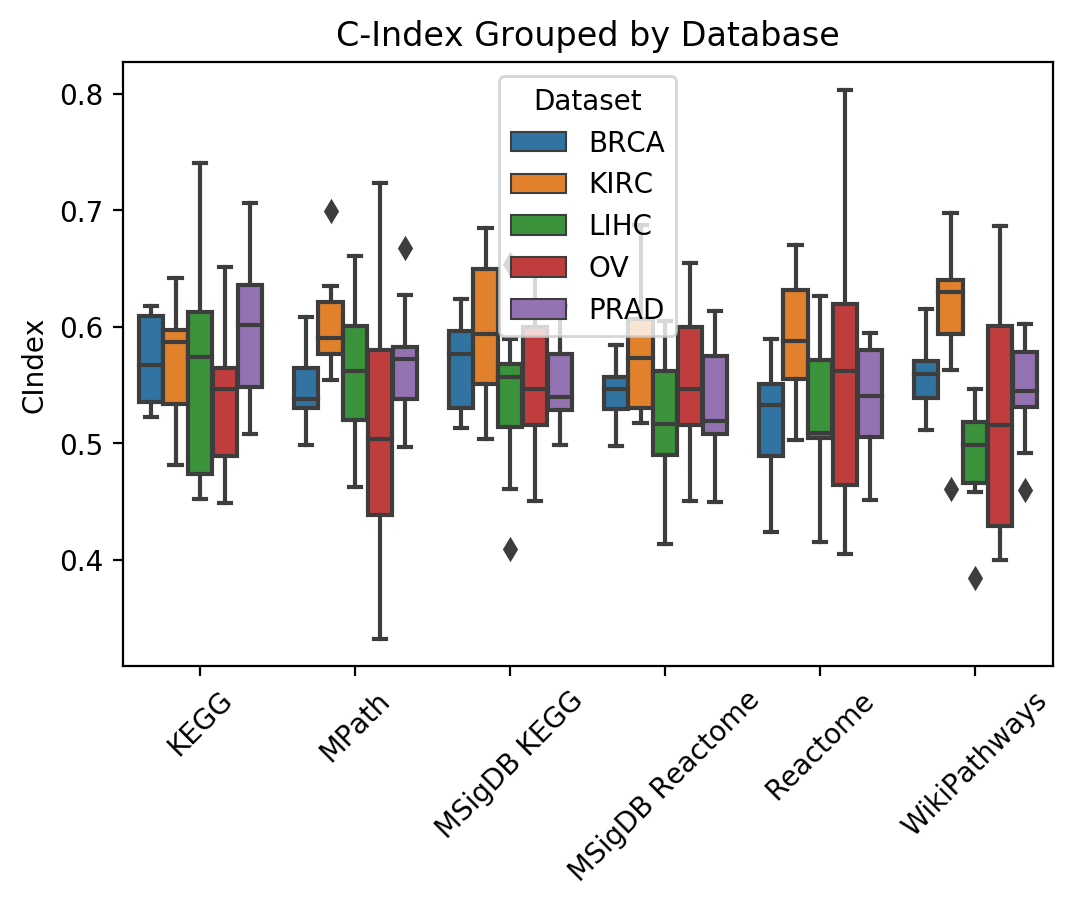

In [10]:
ax = sns.boxplot(
    y='CIndex',
    x='Database',
    hue='Dataset',
    data=df,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('')
plt.title('C-Index Grouped by Database')
plt.show()

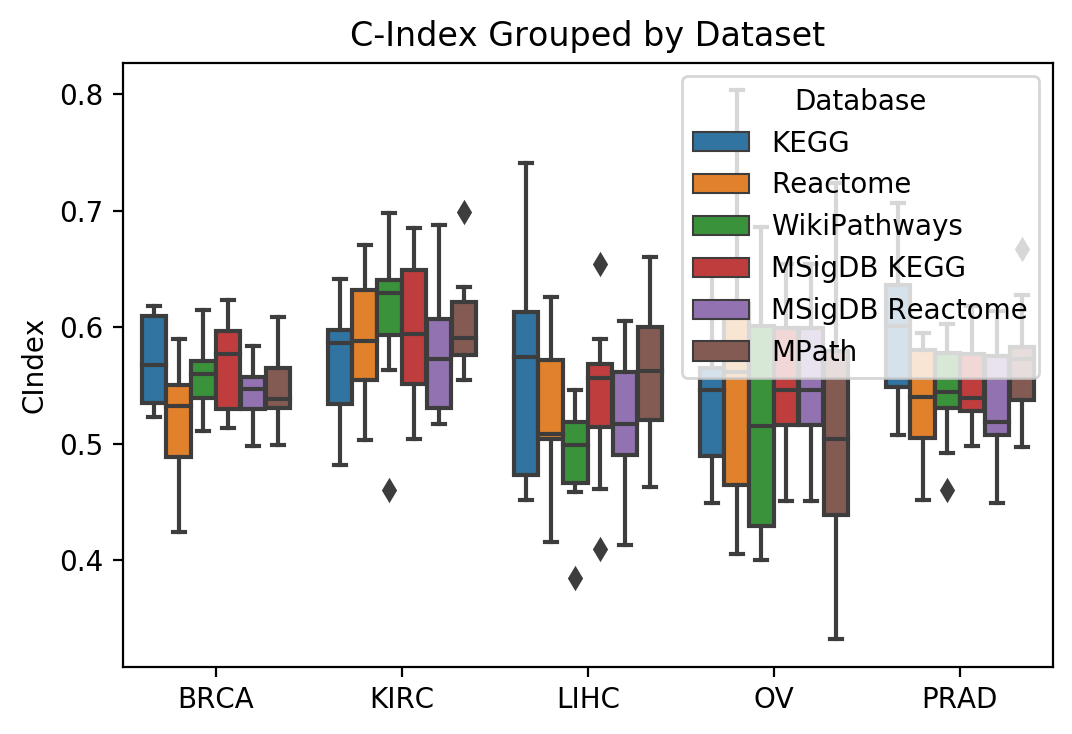

In [11]:
ax = sns.boxplot(
    y='CIndex',
    x='Dataset',
    hue='Database',
    data=df,
    hue_order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'MPath'],
)
plt.xlabel('')
plt.title('C-Index Grouped by Dataset')
plt.show()

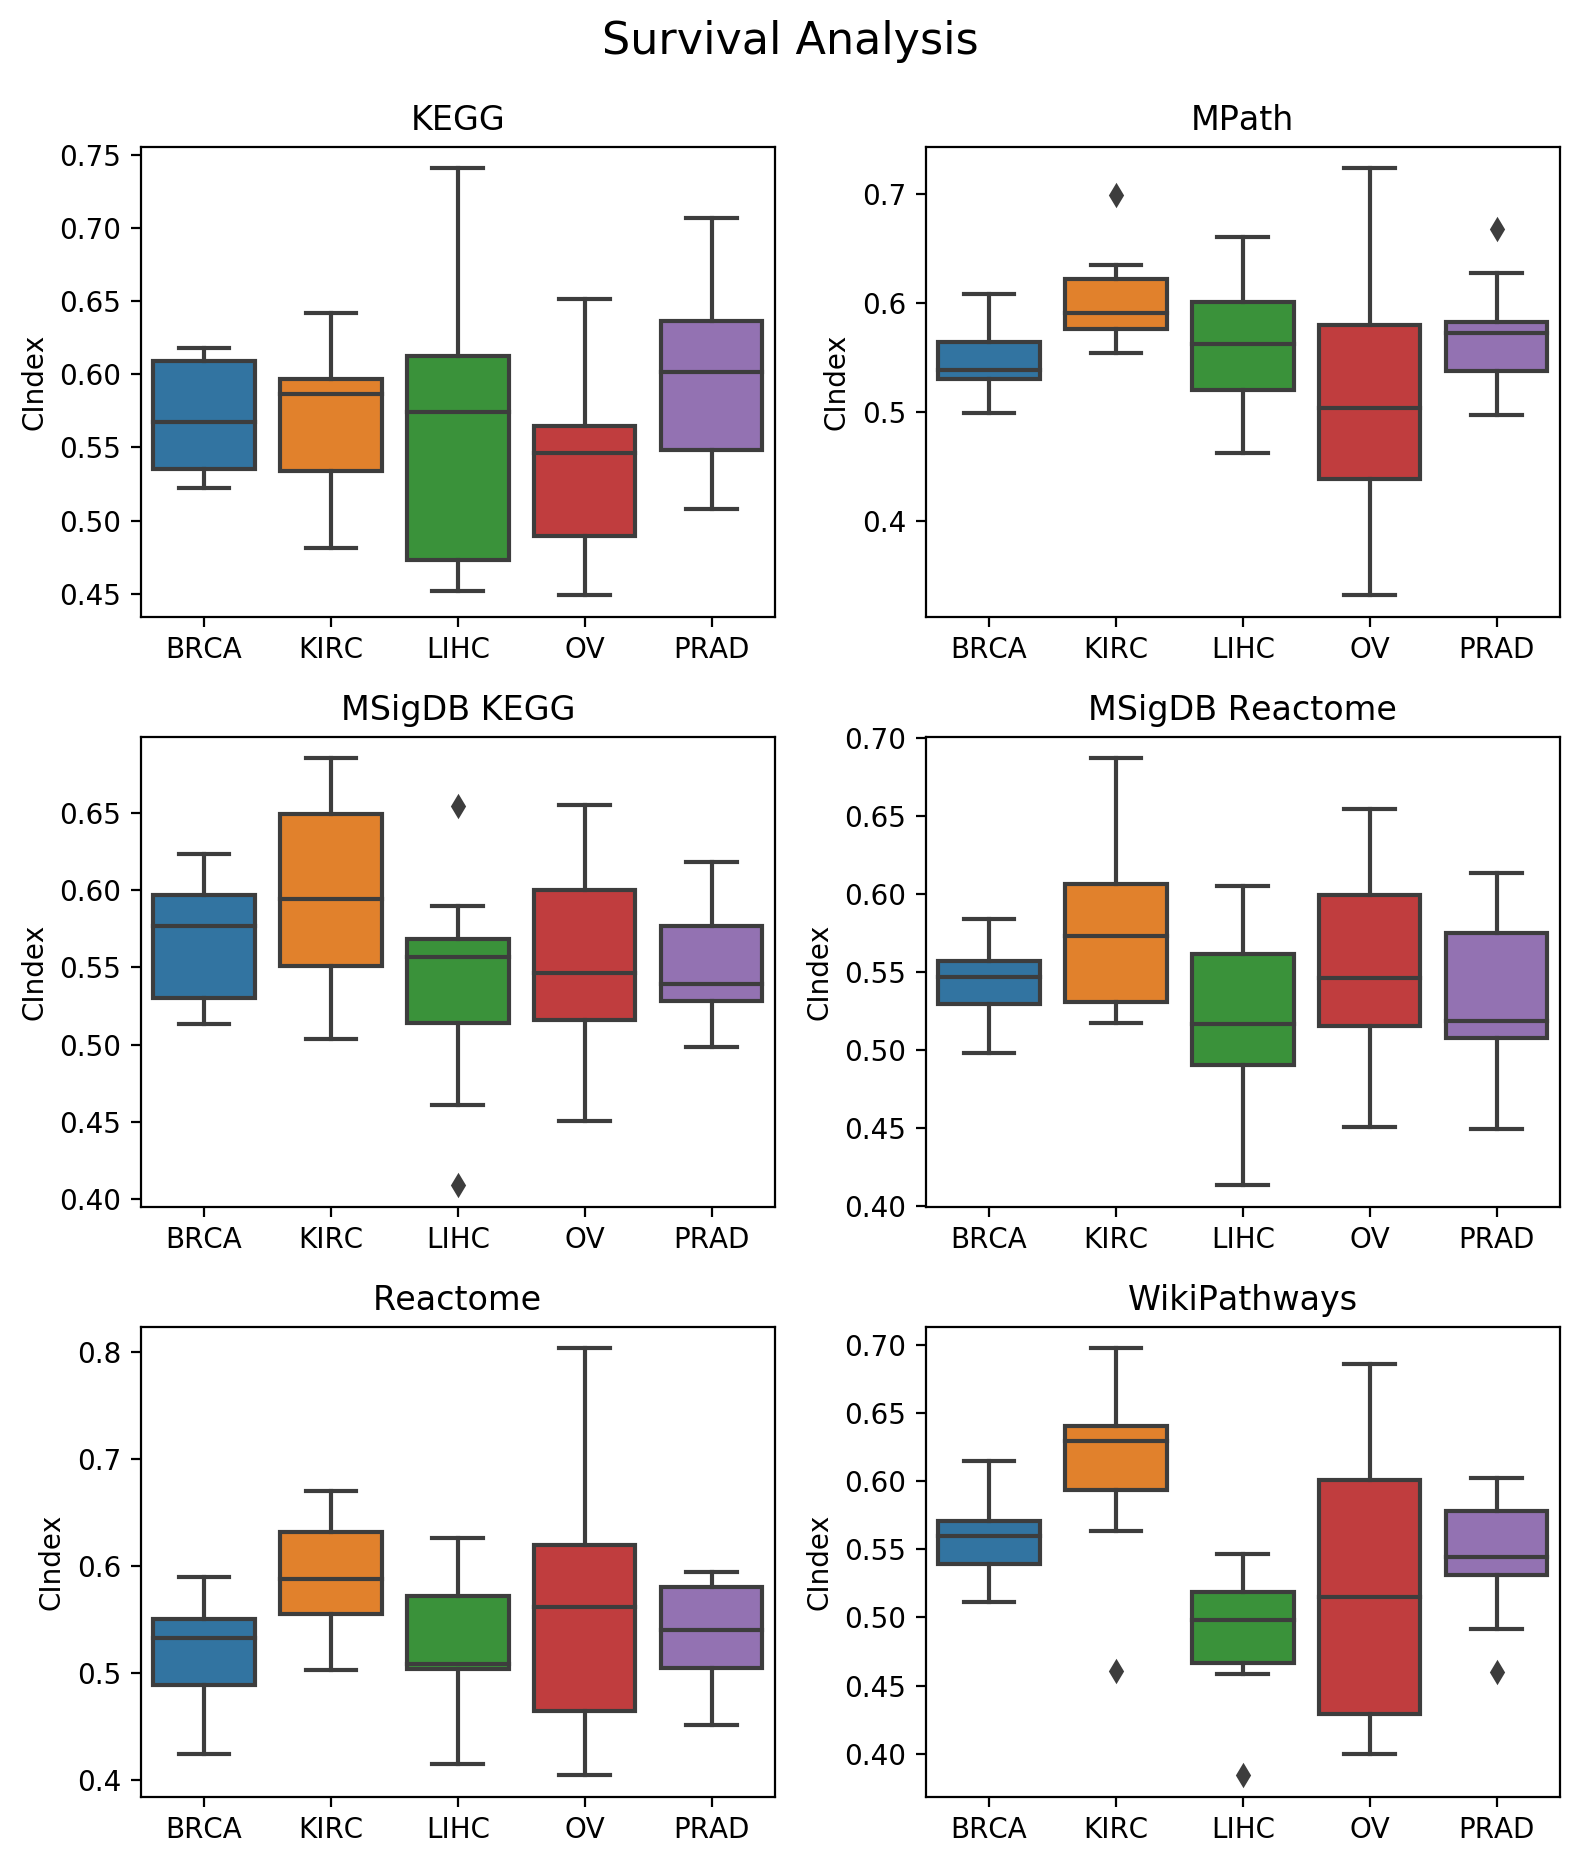

In [12]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 9))

plt.suptitle('Survival Analysis', fontsize=16, y=1.03)

y_min = df['CIndex'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='CIndex',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

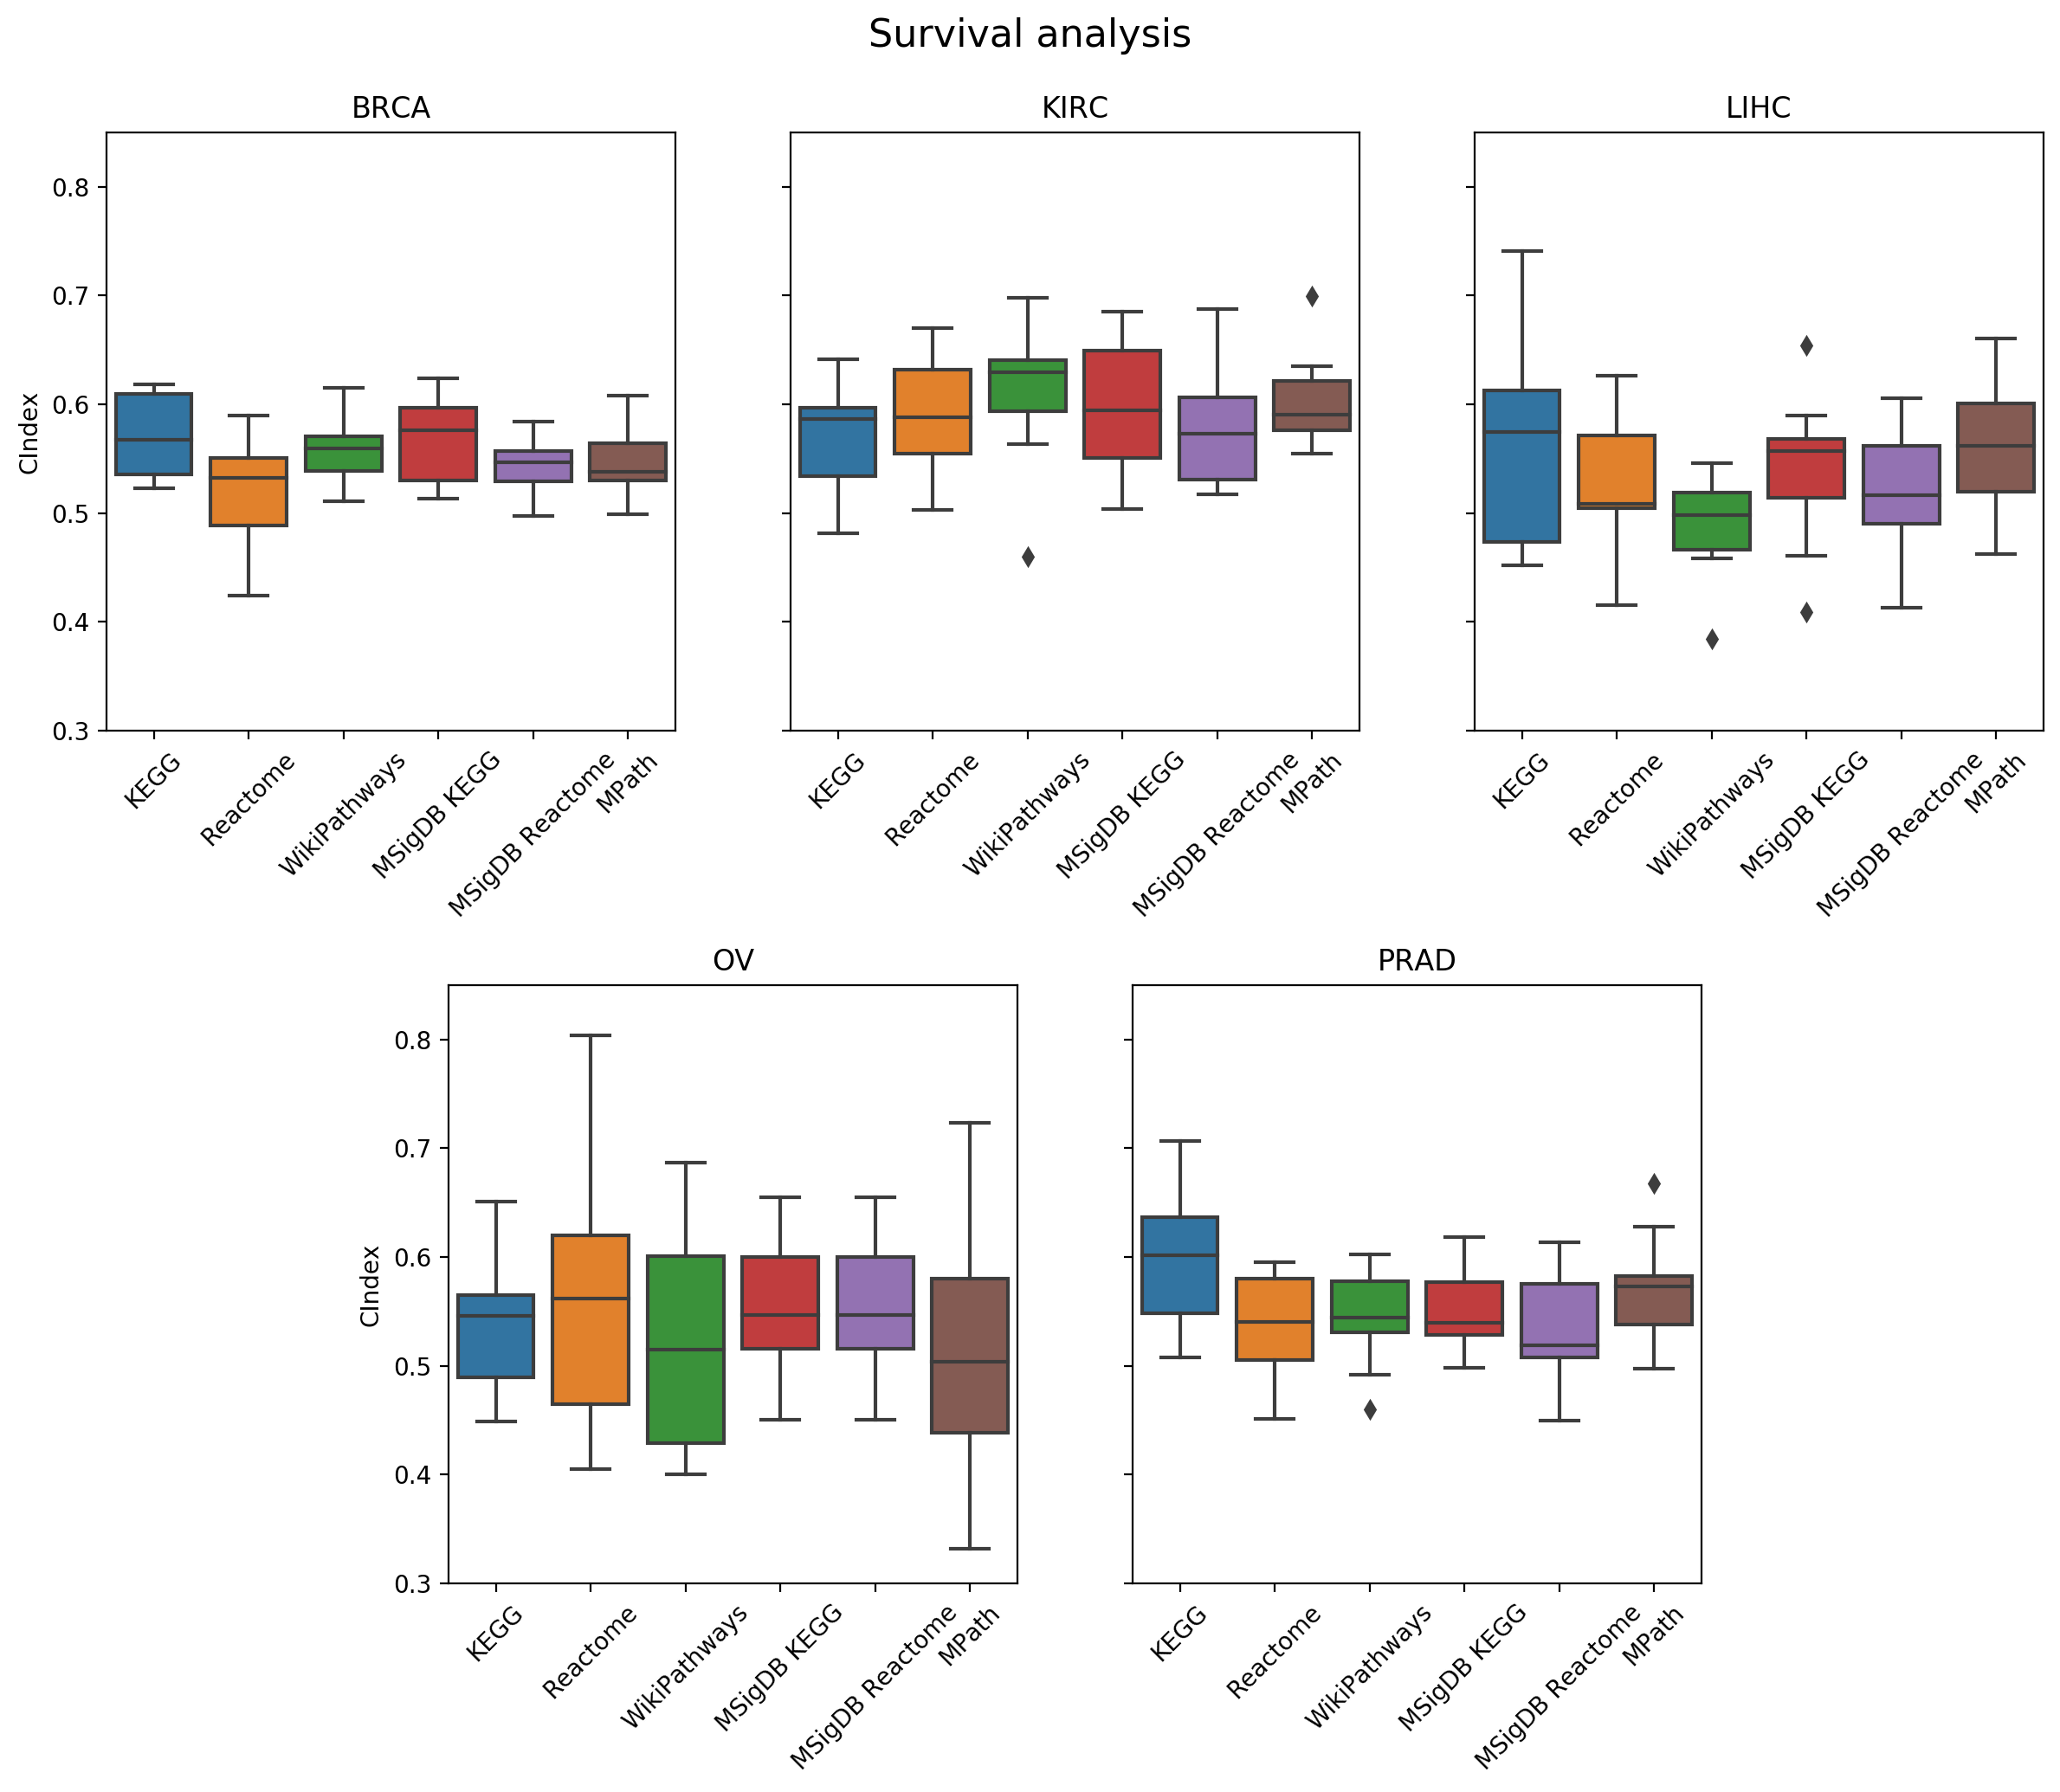

In [13]:
fig = plt.figure(figsize=(12, 10)) 

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

suptitle = plt.suptitle('Survival analysis', fontsize=16, y=1.03)

for plot_num, (dataset, ax) in enumerate(zip(df['Dataset'].unique(), [ax1, ax2, ax3, ax4, ax5])):
    
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='CIndex',
        x='Database',
        data=df[df['Dataset'] == dataset],
        order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'MPath'],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Set y limit
    ax.set_ylim([0.3, 0.85])
    
    # Hide x label in all plots and leave y axis label for the leftmost plots
    ax.set_xlabel('')
    if plot_num in {1,2,4}:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False) 
        
plt.tight_layout()
plt.savefig(
    os.path.join(os.path.expanduser('~'), 'Desktop', 'survival.png'),
    dpi=400,
    bbox_inches='tight', 
    bbox_extra_artists=[suptitle],
)
plt.show()